# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [ ]:
# Load modules
import pickle
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import math
import csv
import scipy.interpolate as interpolate

import os


class TrafficSignClassifier:
    """
    Common class to access methods of the traffic sign classifier
    """

    def __init__(self, folder):
        """
        Initialize TrafficSignClassifier class
        :param folder: Storage folder of training and test data
        """

        # Parameters for the convolutional neural net with 2 dense layers
        self.cnn_depth = 64
        self.dense_layer_1 = 512
        self.dense_layer_2 = 512

        # Load training and test data from pickle file
        train, test = self.load_data(folder)

        # Init internal storage of training, test and validation set
        self.training_features = train[0]
        self.training_labels = train[1]
        self.test_features = test[0]
        self.test_labels = test[1]
        self.valid_features = np.zeros_like(self.training_features)
        self.valid_labels = np.zeros_like(self.training_labels)

        # Read class labels and store them
        self.sign_name = self.load_sign_names("signnames.csv")

        # What's the shape of an image?
        self.image_shape = self.training_features.shape[1:3]
        # How many classes are in the dataset
        self.n_classes = len(set(self.training_labels))

        # Init random generator
        np.random.seed(2000)

        # Store tensorflow placeholders for features and labels
        self.features = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.labels = tf.placeholder(tf.float32, [None, self.n_classes])

        # Initialize tensorflow places
        self.logits = 0
        self.prediction = 0
        self.loss = 0
        self.accuracy = 0

    def train(self, training_epochs=100, batch_size=50, run_optimization=True):
        """
        Run all required methods to train traffic sign classifier optimization
        :param training_epochs:
        :param batch_size:
        :param run_optimization:
        :return:
        """

        # Reshape features for 1d input
        cnn = self.create_cnn()
        self.logits = self.create_deep_layer(flatten(cnn))
        self.define_metrics()

        # Create an operation that initializes all variables
        init = tf.global_variables_initializer()

        # Test model with a small set of training data
        with tf.Session() as session:
            session.run(init)
            session.run(self.loss, feed_dict={self.features: self.training_features[0:2],
                                              self.labels: self.training_labels[0:2]})

        # Run optimization algorithm only if requested
        if run_optimization:

            # Use Adam optimizer and minimize the loss
            opt = tf.train.AdamOptimizer()
            optimizer = opt.minimize(self.loss)

            # Store
            start_time = time.time()

            # Initializing the variables
            init = tf.global_variables_initializer()

            # Launch the graph
            sess = tf.Session()
            sess.run(init)

            # Determine 
            batch_count = int(math.ceil(self.training_features.shape[0] / batch_size))

            # Training cycle
            for epoch_i in range(training_epochs):

                total_loss = []
                total_accuracy = []

                # Run all batches
                for batch_i in range(batch_count):

                    # Get a batch of training features and labels
                    batch_start = batch_i * batch_size

                    batch_features = self.training_features[batch_start:(batch_start + batch_size)]
                    batch_labels = self.training_labels[batch_start:(batch_start + batch_size)]

                    # Run optimizer and determine loss + accuracy for this batch
                    _, l, a = sess.run([optimizer, self.loss, self.accuracy],
                                       feed_dict={self.features: batch_features, self.labels: batch_labels})

                    # Add loss and accuracy of this batch to list
                    total_loss.append(l)
                    total_accuracy.append(a)

                # Calulcate mean of loss and accuracy list + Print this information
                total_loss = np.mean(total_loss)
                total_accuracy = np.mean(total_accuracy)
                print("Epoch {}/{} with Loss of {:.6f} and Accuracy of {:.6f}"
                      .format(epoch_i + 1, training_epochs, total_loss, total_accuracy))

                total_loss = []
                total_accuracy = []

                valid_batch_count = int(math.ceil(self.valid_features.shape[0] / batch_size))

                for batch_i in range(valid_batch_count):
                    # Get a batch of training features and labels
                    batch_start = batch_i * batch_size

                    batch_features = self.valid_features[batch_start:(batch_start + batch_size)]
                    batch_labels = self.valid_labels[batch_start:(batch_start + batch_size)]
                    l, a = sess.run([self.loss, self.accuracy],
                                    feed_dict={self.features: batch_features, self.labels: batch_labels})

                    total_loss.append(l)
                    total_accuracy.append(a)

                total_loss = np.mean(total_loss)
                total_accuracy = np.mean(total_accuracy)

                print("Validation Loss of {:.6f} and Accuracy of {:.6f}".format(total_loss, total_accuracy))

            sess.close()

            # Determine time used for training and print information
            end_time = time.time()
            time_dif = end_time - start_time
            print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    def visualize_training_set(self):
        """
        Visualize the training set
        """
        self.visualize_dataset(self.training_features, self.training_labels, self.n_classes)

    def evaluate_test_set(self, batch_size=50):
        """
        Run current classifier on test set
        """
        total_loss = 0
        total_accuracy = 0
        test_batch_count = int(math.ceil(self.test_features.shape[0] / batch_size))

        # Initializing the variables
        init = tf.global_variables_initializer()

        # Launch the graph
        sess = tf.Session()
        sess.run(init)

        for batch_i in range(test_batch_count):
            # Get a batch of training features and labels
            batch_start = batch_i * batch_size

            batch_features = self.test_features[batch_start:(batch_start + batch_size)]
            batch_labels = self.test_labels[batch_start:(batch_start + batch_size)]
            l, a = sess.run([self.loss, self.accuracy],
                            feed_dict={self.features: batch_features, self.labels: batch_labels})

            total_loss += l
            total_accuracy += a
        sess.close()

        total_loss /= test_batch_count
        total_accuracy /= test_batch_count

        print("Test Loss of {:.6f} and Accuracy of {:.6f}".format(total_loss, total_accuracy))

    def evaluate_image(self, image_list):
        """
        Determine traffic sign class for all images in given list
        :param image_list: np array containing all images that should be evaluated
        """


    @staticmethod
    def load_data(folder):
        """
        Load training and test data from given folder and unpack them
        :param folder: Storage folder of training and test data
        :return: training and test data
        """
        training_file = os.path.join(folder, 'train.p')
        testing_file = os.path.join(folder, 'test.p')

        with open(training_file, mode='rb') as f:
            train = pickle.load(f)
        with open(testing_file, mode='rb') as f:
            test = pickle.load(f)

        # Unpack training and test data
        X_train, y_train = train['features'], train['labels']
        X_test, y_test = test['features'], test['labels']

        return (X_train, y_train), (X_test, y_test)

    @staticmethod
    def load_sign_names(filename):
        """
        Load sign names from csv file
        :param filename: csv file with class id in the first and sign name in the second column
        :return: list with sign names
        """

        with open(filename, 'r') as f:
            reader = csv.reader(f)
            sign_names = list(reader)

        return sign_names[1:]

    @staticmethod
    def visualize_dataset(features, labels, n_classes):
        """
        Visualize the given features and labels.
        It shows a histogram of the distribution of classes and examples of the classes.
        :param features: List of evaluated features
        :param labels: List of evaluated labels
        """

        # Create a histogram of training lables
        fig = plt.figure()
        n, bins, patches = plt.hist(labels, n_classes)

        plt.xlabel('Traffic Sign Classes')
        plt.ylabel('occurrences')
        plt.show()

        fig = plt.figure()
        fig.suptitle('Overview Traffic Signs', fontsize=16)

        # Create an overview of trafic sign classes
        pltRows = 5
        pltCols = (n_classes / pltRows) + 1
        for el in range(n_classes):
            for i in range(0, len(labels)):
                if (labels[i] == el):
                    plt.subplot(pltRows, pltCols, el + 1)
                    fig = plt.imshow(features[i, :, :, :], interpolation='nearest')
                    fig.axes.get_xaxis().set_visible(False)
                    fig.axes.get_yaxis().set_visible(False)
                    break
        plt.show()

    @staticmethod
    def pre_process_image(image):
        """
        Convert image to YUV space and normalize results
        :return: Normalized image in yuv space
        """
        yuv = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
        yuv[:, :, 0] = cv2.equalizeHist(yuv[:, :, 0])
        # yuv = yuv[:, :, np.newaxis]
        return (yuv / 255. * 2.) - 1.

    @staticmethod
    def shift_and_rotate_image(img, shift, rotation, scale):
        """
        Shift and rotate image by given coefficients
        :param img: Input image
        :param shift: Tuple for shift in x and y direction
        :param rotation: Rotation in deg
        :param scale: Scaling that should be applied to the image
        :return: Shifted and rotated input image
        """
        rows, cols, c = img.shape

        m = np.float32([[1, 0, shift[0]], [0, 1, shift[0]]])
        shifted = cv2.warpAffine(img, m, (cols, rows))
        m = cv2.getRotationMatrix2D((cols / 2, rows / 2), rotation, scale)
        transformed = cv2.warpAffine(shifted, m, (cols, rows))

        return transformed

    @staticmethod
    def inverse_transform_sampling(input_data, n_bins, n_samples):
        """
        Analyse distribution of input data and draw samples to increase uniformity of the distribution
        Code snippet taken from
        http://www.nehalemlabs.net/prototype/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
        :param input_data:
        :param n_bins:
        :param n_samples:
        :return:
        """
        # Calc histogram of input
        hist, bin_edges = np.histogram(input_data, bins=n_bins, density=True)

        # Inverse histogram and normalize again
        new_hist = 1 / hist
        new_hist = new_hist / sum(new_hist)

        # Calc cumulative sum
        cum_values = np.zeros(bin_edges.shape)
        cum_values[1:] = np.cumsum(new_hist * np.diff(bin_edges))

        inv_cdf = interpolate.interp1d(cum_values, bin_edges)

        # Draw n_samples random numbers and ensure range is within cumulative sum elements
        r = np.random.rand(n_samples) * cum_values[-1]
        return inv_cdf(r)

    def basic_summary(self):
        """
        Give a basic summary on training and test data
        """
        print("Number of training examples =", self.training_features.shape[0])
        print("Number of testing examples =", self.test_features.shape[0])
        print("Image data shape =", self.image_shape)
        print("Number of classes =", self.n_classes)

    def pre_process_features(self):
        """
        Preprocess features to improve performance of classifier
        """
        self.training_features = np.array(
            [self.pre_process_image(self.training_features[i]) for i in range(len(self.training_features))],
            dtype=np.float32)
        self.test_features = np.array(
            [self.pre_process_image(self.test_features[i]) for i in range(len(self.test_features))],
            dtype=np.float32)

    def generate_additional_training_features(self, n_additional_features=10000):
        """
        Generate additional training features to have a more uniform distribution of labels
        """

        new_feature_dist = self.inverse_transform_sampling(self.training_labels, self.n_classes,
                                                           n_additional_features)
        new_feature_dist = np.round(new_feature_dist)
        new_feature_dist = new_feature_dist.astype(int)

        unique, counts = np.unique(new_feature_dist, return_counts=True)

        new_labels = []
        new_features = np.zeros([n_additional_features, self.training_features.shape[1],
                                 self.training_features.shape[2], self.training_features.shape[3]], dtype=np.uint8)

        write_pos = 0
        for ind, number in zip(unique, counts):

            # Get index of existing images of this class
            item_index = np.where(self.training_labels == ind)[0]
            n_items = len(item_index)
            iterations = int(np.ceil(number / n_items))

            image_basis = np.copy(item_index)
            for it in range(iterations - 1):
                np.random.shuffle(item_index)
                image_basis = np.append(image_basis, item_index)

            image_basis = image_basis[0:number]

            for img_number in image_basis:
                img = self.training_features[img_number]

                # shift = np.random.randint(-2, 2, (2, 1))
                shift = (0, 0)
                rot = np.random.randint(-2, 2) * 5
                # scale = float(np.random.randint(90, 110)) / 100.
                scale = 1.0
                img = self.shift_and_rotate_image(img, shift, rot, scale)

                new_labels.append(ind)
                new_features[write_pos, :, :, :] = img
                write_pos += 1

        self.training_features = np.append(self.training_features, new_features, axis=0)
        self.training_labels = np.append(self.training_labels, new_labels)

    def generate_ohe_encoding(self):
        """
        Transform labels to one-hot encoding
        """
        encoder = LabelBinarizer()
        encoder.fit(self.training_labels)
        self.training_labels = encoder.transform(self.training_labels)
        self.valid_labels = encoder.transform(self.valid_labels)
        self.test_labels = encoder.transform(self.test_labels)

    def split_training_set(self):
        """
        Split training set into traning and validation set
        """
        self.training_features, self.valid_features, self.training_labels, self.valid_labels = train_test_split(
            self.training_features,
            self.training_labels,
            test_size=0.15,
            random_state=832289)

    def create_deep_layer(self, dense_input):

        # Store layers weight & bias
        weights = {
            'hidden_layer': tf.Variable(tf.random_normal([dense_input.get_shape().as_list()[-1], self.dense_layer_1])),
            'hidden_layer2': tf.Variable(tf.random_normal([self.dense_layer_1, self.dense_layer_2])),
            'out': tf.Variable(tf.random_normal([self.dense_layer_2, self.n_classes]))
        }
        biases = {
            'hidden_layer': tf.Variable(tf.random_normal([self.dense_layer_1])),
            'hidden_layer2': tf.Variable(tf.random_normal([self.dense_layer_2])),
            'out': tf.Variable(tf.random_normal([self.n_classes]))
        }

        # Hidden layer with RELU activation
        layer_1 = tf.nn.xw_plus_b(dense_input, weights['hidden_layer'], biases['hidden_layer'])
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.nn.xw_plus_b(layer_1, weights['hidden_layer2'], biases['hidden_layer2'])
        layer_2 = tf.nn.relu(layer_2)

        # Output layer with linear activation
        logits = tf.add(tf.matmul(layer_2, weights['out']), biases['out'])

        return logits

    def create_cnn(self):
        """

        :return:
        """

        x = tf.reshape(self.features, (-1, 32, 32, 3))
        # Pad 0s to 36x36. Centers the digit further.
        # Add 2 rows/columns on each side for height and width dimensions.
        x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")

        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, self.cnn_depth)))
        conv1_b = tf.Variable(tf.zeros(self.cnn_depth))
        conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
        conv1 = tf.nn.relu(conv1)

        return conv1

    def define_metrics(self):

        self.prediction = tf.nn.softmax(self.logits)
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(self.logits, self.labels))

        # Determine if the predictions are correct
        is_correct_prediction = tf.equal(tf.argmax(self.prediction, 1), tf.argmax(self.labels, 1))
        # Calculate the accuracy of the predictions
        self.accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))


In [ ]:
# Create a single instance of TrafficSignClassifier
tsc = TrafficSignClassifier('traffic-signs-data')

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [ ]:
### To start off let's do a basic data summary (for details please see the corresponding class methods)
tsc.basic_summary()

In [ ]:
### Show distribution of training samples among the 43 classes and show examples for each class 
### (for details please see the corresponding class methods)
tsc.visualize_training_set()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**

In [ ]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Preprocess the data by converting (for details please see the corresponding class methods)
tsc.generate_additional_training_features()
tsc.pre_process_features()
tsc.generate_ohe_encoding()
tsc.split_training_set()

tsc.train()

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

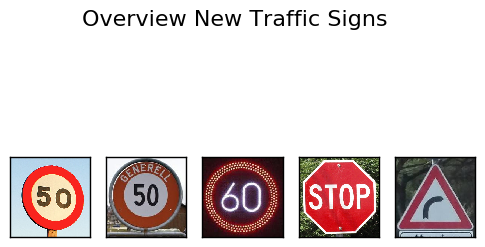

In [2]:
### Load the images and plot them here.
import matplotlib.image as mpimage
import matplotlib.pyplot as plt

filenames = ["local-traffic-signs/img1.png", "local-traffic-signs/img2.png", "local-traffic-signs/img3.png", 
             "local-traffic-signs/img4.png", "local-traffic-signs/img5.png"]

# Create an overview of trafic sign classes and store them in list
fig = plt.figure()
fig.suptitle('Overview New Traffic Signs', fontsize=16)
pltRows = 1
pltCols = 5

new_traffic_signs = []
for el, filename in enumerate(filenames):
    img = mpimage.imread(filename)
    new_traffic_signs.append(img)
    plt.subplot(pltRows, pltCols, el + 1)
    fig = plt.imshow(img, interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.